In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
import tensorflow as tf

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=10000) # just read first 6000 events
df

,0,1,2,3,4,5,6,7,8,9,...,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099
0,3.587869,-2.323472,-2.597121,1.497173,-2.480994,-2.269457,0.848844,-2.465643,-2.096595,0.961511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.921213,-0.745233,1.018857,0.689363,-0.642245,3.050711,1.999174,-0.343135,-0.322586,1.580572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.580352,-2.412026,1.680236,0.429869,-0.778697,-1.453413,0.856914,-2.243512,0.217628,0.407344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.579134,-0.243543,-2.561824,0.312690,-0.283086,-0.281626,0.775053,-2.062494,-1.598718,0.868891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.644219,-2.457281,-2.670996,0.186128,-1.757650,2.719159,0.346987,-2.318233,-0.155036,0.501437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.273899,-0.010251,-1.780153,0.305064,-0.107610,-1.089663,1.755664,-1.770638,-3.117163,0.902534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.730841,-2.293759,-1.150644,2.179489,-1.778682,1.374734,0.831901,-0.847175,-1.478671,1.819629,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.369312,-1.935946,-0.509908,0.396563,-0.114723,-2.044191,3.002075,-0.085780,-1.920424,11.591479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,1.720358,-2.426640,0.815652,0.224197,-0.954293,0.221443,0.229740,-2.043807,-0.719433,0.469830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet_parts = [list(l) for l in jets[k].constituents_array()]
        
        # pad jets
        if (len(jet_parts) < 100):
            pads = 100 - len(jet_parts)
            for p in range(pads):
                jet_parts.append([0,0,0,0])
        else:
            jet_parts = jet_parts[0:100]  # just get 100 particles for this jet (arbitrary)
    
        data.append(jet_parts)

In [7]:
# transform data into format easier for scaling with sklearn ([n_particles, 4])
d = []
for i in range(len(data)):
    for j in range(100):
        d.append(data[i][j])
data = d

In [8]:
data = np.array(data)
data.shape

(14733100, 4)

In [9]:
# splitting data (rounding by 100)
x_train = data[0:int(round(len(data) * 0.8, -2))]
x_val = data[int(round(len(data) * 0.8, -2)):int(round(len(data) * 0.9, -2))]
x_test = data[int(round(len(data) * 0.9, -2)):]

In [10]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [11]:
x_train = np.reshape(x_train, (-1,100,4))
x_val = np.reshape(x_val, (-1,100,4))
x_test = np.reshape(x_test, (-1,100,4))

In [12]:
x_test.shape

(14733, 100, 4)

# VAE Model

In [13]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [14]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
inter_dim_1 = 256
inter_dim_2 = 128
final_dim = 64
latent_dim = 32
input_dim = (100,4)

In [16]:
# encoder
x = Input(shape=input_dim)
x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x_flat)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
z_mean = Dense(latent_dim)(h3)
z_log_sigma = Dense(latent_dim)(h2)

In [17]:
x.shape

TensorShape([None, 100, 4])

In [18]:
# random sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs = x, outputs = z)

In [19]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(np.prod(input_dim), activation='linear')

h3_decoded = decoder_h3(z)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
x_decoded = Reshape(input_dim)(x_decoded_mean)

In [20]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [21]:
mse = keras.losses.MeanSquaredError()
def vae_loss(x, y):
    mse_loss = mse(K.flatten(x), K.flatten(y))
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [22]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 4)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 400)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          102656      flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
________________________________________________________________________________________________

# Train

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
batch_size = 1000
epochs = 100

In [25]:
x_train.shape

(117865, 100, 4)

In [26]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [27]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 117865 samples, validate on 14733 samples
Epoch 1/100
117865/117865 [==============================] - 1s 13us/step - loss: 1.0800 - val_loss: 1.0415
Epoch 2/100
117865/117865 [==============================] - 1s 8us/step - loss: 1.0078 - val_loss: 1.0334
Epoch 3/100
117865/117865 [==============================] - 1s 8us/step - loss: 1.0024 - val_loss: 1.0303
Epoch 4/100
117865/117865 [==============================] - 1s 7us/step - loss: 1.0005 - val_loss: 1.0290
Epoch 5/100
117865/117865 [==============================] - 1s 8us/step - loss: 0.9998 - val_loss: 1.0286
Epoch 6/100
117865/117865 [==============================] - 1s 8us/step - loss: 0.9995 - val_loss: 1.0283
Epoch 7/100
117865/117865 [==============================] - 1s 9us/step - loss: 0.9994 - val_loss: 1.0282
Epoch 8/100
117865/117865 [==============================] - 1s 8us/step - loss: 0.9993 - val_loss: 1.0282
Epoch 9/100
117865/117865 [==============================] - 1s 9us/step - loss: 0.9993 - va

# Visualization

In [28]:
import matplotlib.pyplot as plt

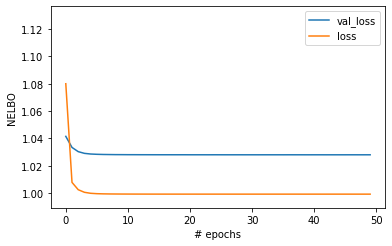

In [29]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [30]:
predictions = K.flatten(vae.predict(x_test))

In [31]:
predictions.shape

TensorShape([5893200])

In [32]:
predictions = tf.dtypes.cast(predictions, tf.float64)

In [33]:
test = K.flatten(x_test)

In [34]:
distr = (test - predictions) / test

In [35]:
stuff = list(range(10))
stuff[1::2]

[1, 3, 5, 7, 9]

In [36]:
pT_pred = predictions[0::4]
eta_pred = predictions[1::4]
phi_pred = predictions[2::4]
mass_pred = predictions[3::4]

In [37]:
pT = test[0::4]
eta = test[1::4]
phi = test[2::4]
mass = test[3::4]

## Stacking output (orange) over input (blue) for pT, eta, phi, m

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.946800e+04, 8.839800e+04, 7.366400e+04,
        2.946500e+04, 5.893000e+04, 1.473500e+04, 2.946800e+04,
        4.419700e+04, 4.419900e+04, 2.946600e+04, 5.893200e+04,
        4.419900e+04, 4.419800e+04, 2.946700e+04, 1.473300e+04,
        4.419900e+04, 1.473400e+04, 1.325970e+05, 1.252307e+06,
        2.696113e+06, 3.683460e+05, 8.839800e+04, 5.893300e+04,
        1.473400e+04, 1.473400e+04, 1.473200e+04, 2.946800e+04,
        4.419700e+04, 2.946700e+04, 7.366200e+04, 1.473500e+04,
        2.946500e+04, 4.000000e+00, 7.366000e+04, 1.473500e+04,
        1.473300e+04, 1.473300e+04, 7.366700e+04, 4.419700e+04,
        5.893000e+04, 2.946800e+04, 1.473100e+04, 2.000000e+00,
        0.000000e+00]),
 array([-0.11      , -0.1055102 , -0.10102041, -0.09653061, -0.09204082,
        -0.08755102, -0.08306122, -0.07857143, -0.07408163, -0.06959184,
        -0.06510204, -0.06061224, -0.05612245, -0.05163265, -0

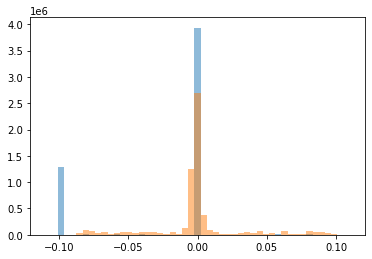

In [38]:
# overeall
bins = np.linspace(-0.11, 0.11, 50)
plt.hist(K.flatten(x_test), bins=bins,alpha=0.5)
plt.hist(predictions, bins=bins,alpha=0.5)

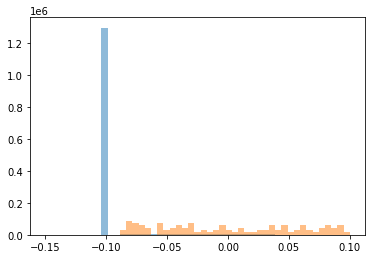

In [39]:
# pT
bins = np.linspace(-0.15, 0.1, 50)
plt.hist(pT, bins=bins,alpha=0.5)
plt.hist(pT_pred, bins=bins,alpha=0.5)
bins = np.linspace(-0.45, -0.2, 40)

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.47320e+04, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 1.47310e+04,
        3.00000e+00, 1.47300e+04, 1.00000e+00, 1.47360e+04, 2.94730e+04,
        1.76787e+05, 1.91527e+05, 1.32620e+05, 5.15618e+05, 3.24121e+05,
        2.94790e+04, 4.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.47320e+04, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([-0.025     , -0.02397959, -0.02295918, -0.02193878, -0.02091837,
        -0.01989796, -0.01887755, -0.01785714, -0.01683673, -0.01581633,
        -0.01479592, -0.01377551, -0.0127551 , -0.01173469, -0.01071429,
        -0.00969388, -0.00867347, -0.00765306, -0.00663265, -0

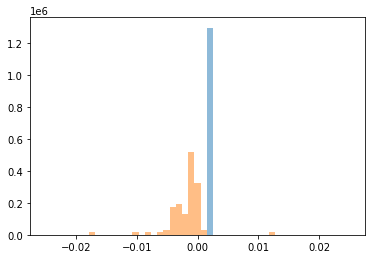

In [40]:
# eta
bins = np.linspace(-0.025, 0.025, 50)
plt.hist(eta, bins=bins,alpha=0.5)
plt.hist(eta_pred, bins=bins,alpha=0.5)

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 2.00000e+00, 5.89280e+04, 7.36690e+04,
        1.32588e+05, 1.32603e+05, 1.47326e+05, 1.76799e+05, 2.50462e+05,
        2.20995e+05, 2.06255e+05, 1.47390e+04, 1.47350e+04, 1.47320e+04,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 1.47310e+04, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.47330e+04,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([-0.025     , -0.02397959, -0.02295918, -0.02193878, -0.02091837,
        -0.01989796, -0.01887755, -0.01785714, -0.01683673, -0.01581633,
        -0.01479592, -0.01377551, -0.0127551 , -0.01173469, -0.01071429,
        -0.00969388, -0.00867347, -0.00765306, -0.00663265, -0

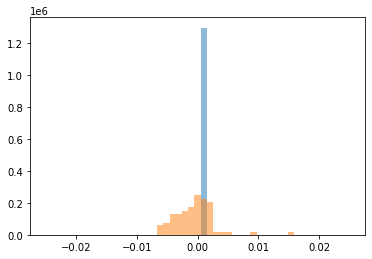

In [41]:
# phi
bins = np.linspace(-0.025,0.025, 50)
plt.hist(phi, bins=bins,alpha=0.5)
plt.hist(phi_pred, bins=bins,alpha=0.5)

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00, 1.47310e+04,
        2.94640e+04, 2.00000e+00, 2.94650e+04, 2.94690e+04, 5.89330e+04,
        4.42050e+04, 1.62049e+05, 5.89370e+04, 1.47329e+05, 1.76800e+05,
        2.65183e+05, 1.91517e+05, 8.84050e+04, 4.42080e+04, 5.89330e+04,
        2.94650e+04, 2.00000e+00, 1.00000e+00, 0.00000e+00, 1.47340e+04,
        2.94620e+04, 3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([-0.025     , -0.02397959, -0.02295918, -0.02193878, -0.02091837,
        -0.01989796, -0.01887755, -0.01785714, -0.01683673, -0.01581633,
        -0.01479592, -0.01377551, -0.0127551 , -0.01173469, -0.01071429,
        -0.00969388, -0.00867347, -0.00765306, -0.00663265, -0

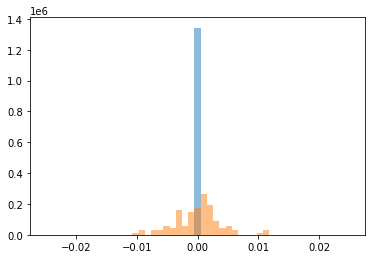

In [42]:
# mass
bins = np.linspace(-0.025,0.025, 50)
plt.hist(mass, bins=bins,alpha=0.5)
plt.hist(mass_pred, bins=bins,alpha=0.5)

In [43]:
d_pT = distr[0::4]
d_eta = distr[1::4]
d_phi = distr[2::4]
d_mass = distr[3::4]

## Distribution of (input - output) / input

In [44]:
bins = np.linspace(-3, 3, 50)

(array([1.91000e+02, 9.24800e+03, 1.39150e+04, 2.65000e+02, 2.08710e+04,
        2.52000e+02, 1.18890e+04, 1.46090e+04, 1.43810e+04, 1.47300e+04,
        3.91000e+02, 4.65000e+02, 5.13000e+02, 1.47550e+04, 6.21000e+02,
        4.33990e+04, 7.80000e+02, 1.53440e+04, 3.13650e+04, 7.28820e+04,
        3.00150e+04, 3.04110e+04, 1.64380e+04, 5.16500e+04, 5.88730e+04,
        1.05362e+05, 1.79541e+05, 1.08529e+05, 1.18869e+05, 1.59827e+05,
        1.46081e+05, 1.29732e+05, 6.92315e+05, 1.94899e+05, 2.30069e+05,
        2.61342e+05, 3.27385e+05, 2.09103e+05, 1.46257e+05, 1.65957e+05,
        1.03191e+05, 6.32980e+04, 3.89950e+04, 1.33100e+04, 1.04855e+05,
        8.88710e+04, 4.00680e+04, 6.23330e+04, 5.28480e+04]),
 array([-3.        , -2.87755102, -2.75510204, -2.63265306, -2.51020408,
        -2.3877551 , -2.26530612, -2.14285714, -2.02040816, -1.89795918,
        -1.7755102 , -1.65306122, -1.53061224, -1.40816327, -1.28571429,
        -1.16326531, -1.04081633, -0.91836735, -0.79591837, -0

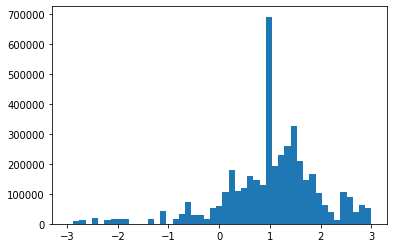

In [45]:
plt.hist(distr, bins=bins)

(array([   188.,    223.,    210.,    261.,    241.,    249.,    325.,
           345.,    333.,    392.,    386.,    460.,    510.,    541.,
           613.,    714.,    769.,    946.,    991.,   1199.,   1406.,
          1707.,   2017.,   2571.,   3267.,  62570., 164983.,  80386.,
        118749., 102723.,  88527.,  67094., 142682.,  61275.,  42960.,
         81549.,  91559.,  90438.,  40249., 112860.,  74858.,   1464.,
          1397.,   1267.,   1274.,   1098.,   1108.,   1036.,    954.]),
 array([-3.        , -2.87755102, -2.75510204, -2.63265306, -2.51020408,
        -2.3877551 , -2.26530612, -2.14285714, -2.02040816, -1.89795918,
        -1.7755102 , -1.65306122, -1.53061224, -1.40816327, -1.28571429,
        -1.16326531, -1.04081633, -0.91836735, -0.79591837, -0.67346939,
        -0.55102041, -0.42857143, -0.30612245, -0.18367347, -0.06122449,
         0.06122449,  0.18367347,  0.30612245,  0.42857143,  0.55102041,
         0.67346939,  0.79591837,  0.91836735,  1.04081633,  1.

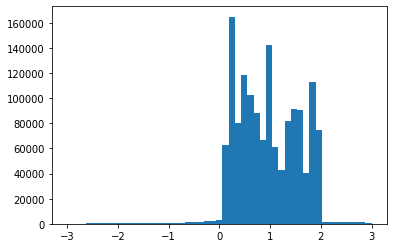

In [46]:
plt.hist(d_pT, bins=bins)

(array([1.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00,
        1.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00,
        0.00000e+00, 3.00000e+00, 1.00000e+00, 3.00000e+00, 3.00000e+00,
        3.00000e+00, 3.00000e+00, 3.00000e+00, 9.00000e+00, 5.00000e+00,
        9.00000e+00, 8.00000e+00, 1.00000e+01, 1.90000e+01, 1.40000e+01,
        2.20000e+01, 2.80000e+01, 4.70000e+01, 4.50000e+01, 1.39590e+04,
        4.28230e+04, 2.98420e+04, 2.18055e+05, 8.56980e+04, 1.46199e+05,
        1.27447e+05, 1.68299e+05, 9.46960e+04, 6.69750e+04, 4.08470e+04,
        1.43640e+04, 5.06270e+04, 1.29440e+04, 1.20330e+04, 6.20230e+04,
        6.35160e+04, 2.50950e+04, 3.63340e+04, 2.34540e+04]),
 array([-3.        , -2.87755102, -2.75510204, -2.63265306, -2.51020408,
        -2.3877551 , -2.26530612, -2.14285714, -2.02040816, -1.89795918,
        -1.7755102 , -1.65306122, -1.53061224, -1.40816327, -1.28571429,
        -1.16326531, -1.04081633, -0.91836735, -0.79591837, -0

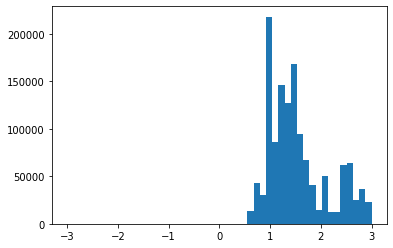

In [47]:
plt.hist(d_eta, bins=bins)

(array([1.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00, 8.78600e+03,
        1.00000e+00, 1.15620e+04, 2.00000e+00, 1.00000e+00, 4.00000e+00,
        4.00000e+00, 1.00000e+00, 2.00000e+00, 2.00000e+00, 5.00000e+00,
        4.26770e+04, 7.00000e+00, 1.43940e+04, 2.86590e+04, 7.16760e+04,
        2.86000e+04, 2.86960e+04, 1.44100e+04, 3.50580e+04, 5.55850e+04,
        4.27700e+04, 1.45180e+04, 2.80780e+04, 2.80000e+01, 4.30540e+04,
        1.43970e+04, 2.90250e+04, 2.15296e+05, 3.88890e+04, 1.31350e+04,
        3.78720e+04, 5.29260e+04, 2.39630e+04, 2.44860e+04, 1.22490e+04,
        1.39670e+04, 1.12060e+04, 2.46540e+04, 1.00000e+01, 2.69860e+04,
        2.42550e+04, 1.38630e+04, 2.49620e+04, 1.38890e+04]),
 array([-3.        , -2.87755102, -2.75510204, -2.63265306, -2.51020408,
        -2.3877551 , -2.26530612, -2.14285714, -2.02040816, -1.89795918,
        -1.7755102 , -1.65306122, -1.53061224, -1.40816327, -1.28571429,
        -1.16326531, -1.04081633, -0.91836735, -0.79591837, -0

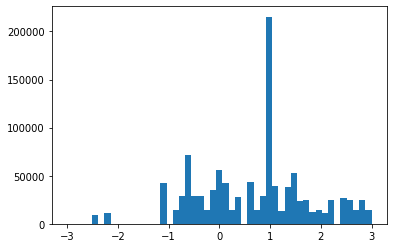

In [48]:
plt.hist(d_phi, bins=bins)